#### Import libraries

In [155]:
from pyproj import CRS
import geopandas as gpd

# Import libraries
import pandas as pd
import geopandas as gpd
import re
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib
import contextily as ctx
from pyproj import CRS
from geopandas.tools import geocode
import requests
import geojson
import mplleaflet
import folium

#### Function to read population shape files

In [156]:
def read_population_data(year):
    
    # Define path to file
    fp = "population_data/"+str(year)+"/Vaestotietoruudukko_"+str(year)+".shp"
    
    # Read shapefile
    pop = gpd.read_file(fp)
    
    # Define coordinate reference system
    pop.crs = CRS.from_epsg(3879).to_wkt()
    
    # Drop columns if number of resudents is less than 0 (no value) or over 10000 (values without real location)
    pop = pop[(pop["ASUKKAITA"] > 0) & (pop["ASUKKAITA"] < 10000)]
    
    # Drop all the columns except index and asukkaita
    pop_pop = pop[["INDEX", "ASUKKAITA"]]
    pop_geom = pop[["INDEX", "geometry"]]
    
    # Print number of residents by year
    print(year, "number of residents:", pop_pop["ASUKKAITA"].sum())
    
    # Rename column asukkaita to pop+year
    pop_pop = pop_pop.rename(columns={'ASUKKAITA': 'pop'+str(year)})
    
    # Rename column geometry to geometry+year. Must do to later fill missing values and merge tables.
    pop_geom = pop_geom.rename(columns={'geometry': 'geometry'+str(year)})
    
    # Set column INDEX to INDEX
    pop_pop = pop_pop.set_index("INDEX")
    pop_geom = pop_geom.set_index("INDEX")
    
    # Return result geodataframe
    return pop_pop, pop_geom

#### Read the files

In [157]:
# Data is available from years 1997-2003 and 2008-2019

# Years 1997 to 2003
#pop1997_pop, pop1997_geom = read_population_data(1997)
#pop1998_pop, pop1998_geom = read_population_data(1998)
#pop1999_pop, pop1999_geom = read_population_data(1999)
#pop2000_pop, pop2000_geom = read_population_data(2000)
#pop2001_pop, pop2001_geom = read_population_data(2001)
#pop2002_pop, pop2002_geom = read_population_data(2002)
#pop2003_pop, pop2003_geom = read_population_data(2003)

# Years 2008 to 2012
#pop2008_pop, pop2008_geom = read_population_data(2008)
#pop2009_pop, pop2009_geom = read_population_data(2009)
#pop2010_pop, pop2010_geom = read_population_data(2010)
#pop2011_pop, pop2011_geom = read_population_data(2011)
#pop2012_pop, pop2012_geom = read_population_data(2012)

# Years 2013 to 2019
pop2013_pop, pop2013_geom = read_population_data(2013)
pop2014_pop, pop2014_geom = read_population_data(2014)
pop2015_pop, pop2015_geom = read_population_data(2015)
pop2016_pop, pop2016_geom = read_population_data(2016)
pop2017_pop, pop2017_geom = read_population_data(2017)
pop2018_pop, pop2018_geom = read_population_data(2018)
pop2019_pop, pop2019_geom = read_population_data(2019)

2013 number of residents: 1049988
2014 number of residents: 1076765
2015 number of residents: 1087308
2016 number of residents: 1111940
2017 number of residents: 1121567
2018 number of residents: 1137053
2019 number of residents: 1155285


## Join tables

#### Result will have 3 dataframes. One for 1997 to 2003, one for 2008 to 2012 and one for 2013 to 2019.

#### Hox! Between years 1997 and 2012 grid size 500m x 500m. Since 2013 grid size 250m x 250m.

In [158]:
from functools import reduce

# Combine dataframes to lists
pop_list = [pop2013_pop, pop2014_pop, pop2015_pop, pop2016_pop, pop2017_pop, pop2018_pop, pop2019_pop]
geom_list = [pop2013_geom, pop2014_geom, pop2015_geom, pop2016_geom, pop2017_geom, pop2018_geom, pop2019_geom]

# Merge dataframes
pop = reduce(lambda left,right: pd.merge(left,right,on='INDEX', how="outer"), pop_list)
geom = reduce(lambda left,right: pd.merge(left,right,on='INDEX', how="outer"), geom_list)

# Fill missing population values with 0
pop = pop.fillna(0)

# Fill missing geometry value from left
geom["geometry"] = geom.apply(lambda x:  x[x.last_valid_index()], axis=1)
geom = geom["geometry"]

# Merge dataframes pop and geom
population = pop.join(geom)

# Convert dataframe back to geodataframe
population = gpd.GeoDataFrame(population)

population.crs = CRS.from_epsg(3879).to_wkt()

# Show dataframe
population

,pop2013,pop2014,pop2015,pop2016,pop2017,pop2018,pop2019,geometry
INDEX,,,,,,,,
688,5.0,8.0,8.0,7.0,9.0,9.0,0.0,"POLYGON Z ((25472499.995 6689749.005 0.000, 25..."
703,6.0,6.0,6.0,6.0,0.0,5.0,5.0,"POLYGON Z ((25472499.995 6685998.998 0.000, 25..."
710,7.0,8.0,8.0,8.0,8.0,8.0,8.0,"POLYGON Z ((25472499.995 6684249.004 0.000, 25..."
711,7.0,7.0,7.0,7.0,5.0,5.0,5.0,"POLYGON Z ((25472499.995 6683999.005 0.000, 25..."
715,16.0,16.0,19.0,17.0,12.0,11.0,12.0,"POLYGON Z ((25472499.995 6682998.998 0.000, 25..."
...,...,...,...,...,...,...,...,...
22925,0.0,0.0,0.0,0.0,0.0,0.0,7.0,"POLYGON Z ((25506749.994 6678999.002 0.000, 25..."
23032,0.0,0.0,0.0,0.0,0.0,0.0,7.0,"POLYGON Z ((25507000.000 6692749.005 0.000, 25..."
23355,0.0,0.0,0.0,0.0,0.0,0.0,21.0,"POLYGON Z ((25507499.995 6692999.004 0.000, 25..."


#### Visualize results

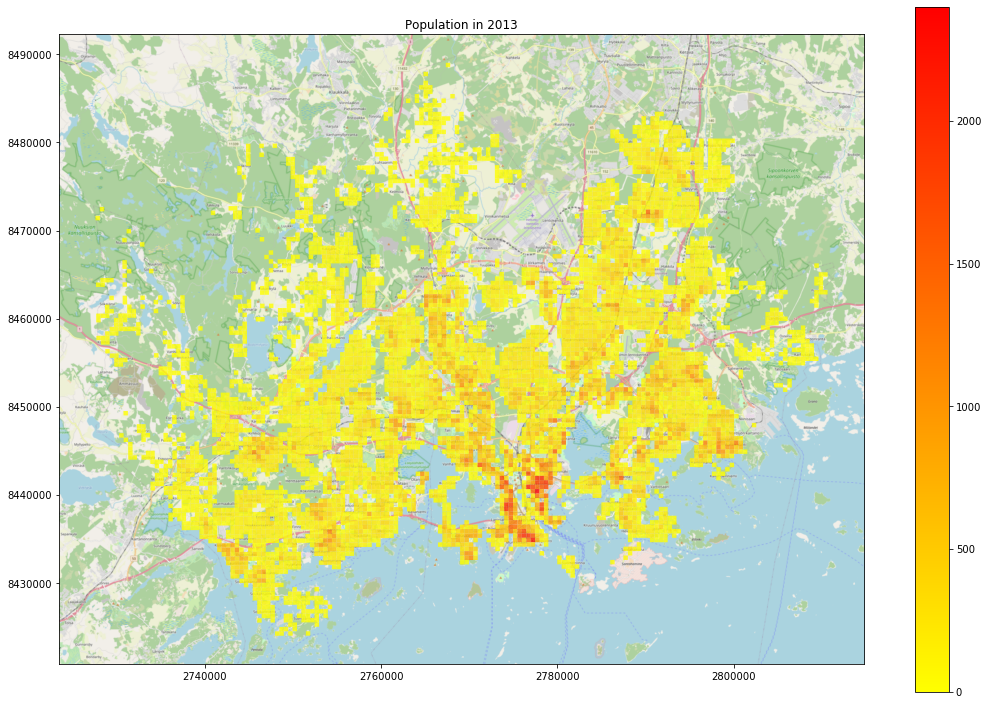

In [159]:
# Set year
year = 2013

#pop = pop_before_2013.to_crs(epsg=3857)
pop = population.to_crs(epsg=3857)

# Initialize plot
fig, ax = plt.subplots(figsize=(15,10))

# Define colour map (reverse autumn_r)
cmap = matplotlib.cm.autumn
cmap_reversed = matplotlib.cm.get_cmap('autumn_r')

# Visualize the areas
#data.plot(ax=ax, column="time_avg", cmap="viridis", linewidth=0, legend=False, alpha=0.9)
im = pop.plot(ax=ax, column="pop"+str(year), cmap=cmap_reversed, linewidth=0.8, legend=True, alpha=0.8)

# Add titles to figures
ax.set_title("Population in " + str(year))

# Use tight layout in plot
plt.tight_layout()

# Plot the addresses
#pop2019.plot(ax=ax, color="red", markersize=100)

# Add basemap with `ST_TONER` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

# Define output filename for the figure in here and use it when saving the file:
output_fig = "docs/"+str(year)+".png"

# Save figure with given name
#plt.savefig(output_fig)

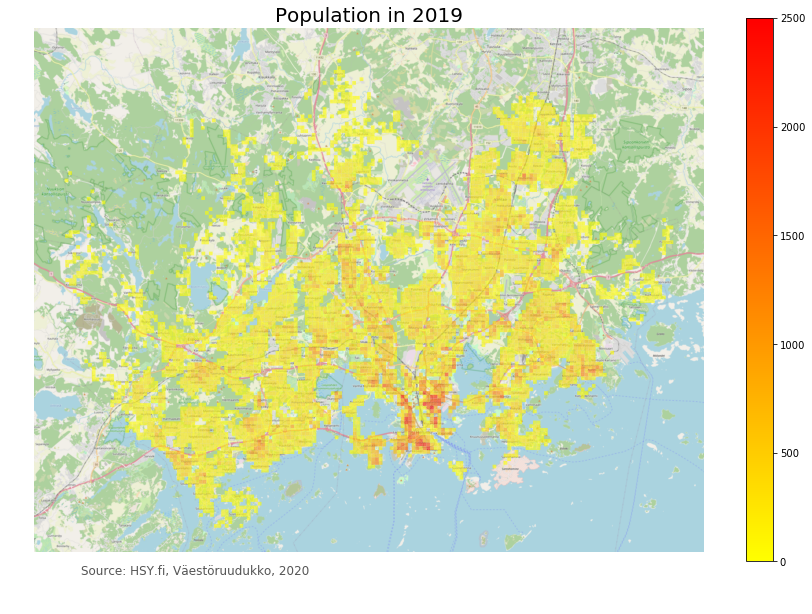

In [166]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define population year
year = 2019

# Set coordinate reference system to mach background map
pop = population.to_crs(epsg=3857)

# set the range for the choropleth
vmin, vmax = 0, 2500

# Set column name which to visualize
column_name = "pop"+str(year)

# Define colour map (reverse autumn_r)
cmap = matplotlib.cm.autumn
cmap_reversed = matplotlib.cm.get_cmap('autumn_r')

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 10))

# Plot the data
pop.plot(ax=ax, column=column_name, cmap=cmap_reversed, linewidth=0.6, alpha=0.6)

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Population in " +str(year), fontdict={"fontsize": "20", "fontweight" : "3"})

# Add source to the bottom left corner
ax.annotate("Source: HSY.fi, Väestöruudukko, 2020",xy=(0.1, .08), xycoords="figure fraction", 
            horizontalalignment="left", verticalalignment="top", fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=cmap_reversed, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbar = fig.colorbar(sm)

# Add basemap with `ST_TONER` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

#saving our map as .png file.
fig.savefig("docs/"+column_name+".png", dpi=200)